# Task 1: Exploratory Data Analysis and Data Preprocessing

## Intelligent Complaint Analysis for Financial Services

This notebook performs comprehensive exploratory data analysis and preprocessing of the CFPB complaint dataset for the RAG-powered chatbot project.

**Objectives:**
- Load and explore the CFPB complaint dataset
- Analyze complaint distributions across financial products
- Perform text analysis on complaint narratives
- Clean and filter data for the specified products
- Prepare data for embedding and vector store creation

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import os
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import textstat
from wordcloud import WordCloud
import re
from datetime import datetime
import zipfile
import requests
from io import BytesIO

# Configure plotting
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
sns.set_palette("husl")

# Set up NLTK - download required resources
nltk_resources = ['punkt', 'punkt_tab', 'stopwords']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource.startswith('punkt') else f'corpora/{resource}')
    except LookupError:
        print(f"Downloading NLTK resource: {resource}")
        nltk.download(resource, quiet=True)

print("Libraries imported successfully!")

print(f"Current working directory: {os.getcwd()}")

Libraries imported successfully!
Current working directory: c:\.vscode\jupiter\Intelligent-Complaint-Analysis-for-Financial-Services\notebooks
Libraries imported successfully!
Current working directory: c:\.vscode\jupiter\Intelligent-Complaint-Analysis-for-Financial-Services\notebooks


## 1. Data Loading and Initial Exploration

We'll load the CFPB complaint dataset and perform initial exploration to understand the structure and content of the data.

In [17]:
# Load the CFPB complaint dataset
# URL for the Consumer Complaint Database
data_url = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"

# Check if data already exists
data_path = "../data/complaints.csv"
if not os.path.exists(data_path):
    print("Downloading CFPB complaint dataset...")
    
    # Download the dataset
    response = requests.get(data_url)
    if response.status_code == 200:
        # Extract the CSV from the zip file
        with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
            zip_file.extractall("../data/")
        print("Dataset downloaded and extracted successfully!")
    else:
        print(f"Failed to download dataset. Status code: {response.status_code}")
else:
    print("Dataset already exists locally.")

# Load the dataset
print("Loading dataset...")
df = pd.read_csv(data_path, nrows=50000, low_memory=False)

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset already exists locally.
Loading dataset...
Dataset loaded successfully!
Dataset shape: (50000, 18)
Memory usage: 50.85 MB
Dataset loaded successfully!
Dataset shape: (50000, 18)
Memory usage: 50.85 MB


In [18]:
# Initial data exploration
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\n=== FIRST FEW ROWS ===")
print(df.head())

print("\n=== DATA TYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES ===")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

print("\n=== BASIC STATISTICS ===")
print(df.describe(include='all'))

=== DATASET OVERVIEW ===
Shape: (50000, 18)
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

=== FIRST FEW ROWS ===
  Date received                                            Product  \
0    2025-06-20  Credit reporting or other personal consumer re...   
1    2025-06-20                                    Debt collection   
2    2025-06-20  Credit reporting or other personal consumer re...   
3    2025-06-20  Credit reporting or other personal consumer re...   
4    2025-06-20  Credit reporting or other personal consumer re...   

               Sub-product                                 Issue  \
0         Credit reporting  Incorrect information on your report   
1  Telecommunications debt     Attempts 

## 2. Product Distribution Analysis

Let's analyze the distribution of complaints across different financial products, with focus on our target products: Credit card, Personal loan, Buy Now Pay Later (BNPL), Savings account, and Money transfers.

In [19]:
# Define our target products
target_products = [
    'Credit card',
    'Personal loan', 
    'Buy Now, Pay Later (BNPL)',
    'Savings account',
    'Money transfers'
]

# Check unique products in the dataset
print("=== ALL PRODUCTS IN DATASET ===")
product_counts = df['Product'].value_counts()
print(product_counts)

print(f"\nTotal unique products: {len(product_counts)}")
print(f"Total complaints: {len(df)}")

# Map similar product names to our target products
product_mapping = {
    'Credit card or prepaid card': 'Credit card',
    'Payday loan, title loan, or personal loan': 'Personal loan',
    'Payday loan, title loan, personal loan, or advance loan': 'Personal loan',
    'Money transfer, virtual currency, or money service': 'Money transfers',
    'Money transfers': 'Money transfers',
    'Checking or savings account': 'Savings account',
    'Bank account or service': 'Savings account',
    'Credit card': 'Credit card',
    'Personal loan': 'Personal loan',
    'Buy Now, Pay Later (BNPL)': 'Buy Now, Pay Later (BNPL)',
    'Savings account': 'Savings account'
}

# Apply mapping and filter
df['Product_mapped'] = df['Product'].map(product_mapping)
df['Product_mapped'] = df['Product_mapped'].fillna('Other')

print("\n=== MAPPED PRODUCT DISTRIBUTION ===")
mapped_counts = df['Product_mapped'].value_counts()
print(mapped_counts)

# Filter for target products
df_filtered = df[df['Product_mapped'].isin(target_products)].copy()
print(f"\nFiltered dataset shape: {df_filtered.shape}")
print(f"Percentage of original data retained: {len(df_filtered)/len(df)*100:.2f}%")

=== ALL PRODUCTS IN DATASET ===
Credit reporting or other personal consumer reports        46253
Debt collection                                             2171
Credit card                                                  569
Checking or savings account                                  331
Money transfer, virtual currency, or money service           228
Mortgage                                                     122
Vehicle loan or lease                                        109
Student loan                                                 107
Payday loan, title loan, personal loan, or advance loan       68
Debt or credit management                                     24
Prepaid card                                                  18
Name: Product, dtype: int64

Total unique products: 11
Total complaints: 50000

=== MAPPED PRODUCT DISTRIBUTION ===
Other              48804
Credit card          569
Savings account      331
Money transfers      228
Personal loan         68
Name: Produc

In [20]:
# Visualize product distribution
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('All Products (Top 10)', 'Target Products Distribution', 
                   'Target Products Over Time', 'Complaints by Company Type'),
    specs=[[{"type": "bar"}, {"type": "pie"}],
           [{"type": "scatter"}, {"type": "bar"}]]
)

# Top 10 products
top_products = product_counts.head(10)
fig.add_trace(
    go.Bar(x=top_products.index, y=top_products.values, name="All Products"),
    row=1, col=1
)

# Target products pie chart
target_counts = df_filtered['Product_mapped'].value_counts()
fig.add_trace(
    go.Pie(labels=target_counts.index, values=target_counts.values, name="Target Products"),
    row=1, col=2
)

# Time series of complaints for target products
df_filtered['Date received'] = pd.to_datetime(df_filtered['Date received'])
df_filtered['Year'] = df_filtered['Date received'].dt.year
yearly_complaints = df_filtered.groupby(['Year', 'Product_mapped']).size().reset_index(name='Count')

for product in target_products:
    product_data = yearly_complaints[yearly_complaints['Product_mapped'] == product]
    fig.add_trace(
        go.Scatter(x=product_data['Year'], y=product_data['Count'], 
                  name=product, mode='lines+markers'),
        row=2, col=1
    )

# Company distribution (top 10)
company_counts = df_filtered['Company'].value_counts().head(10)
fig.add_trace(
    go.Bar(x=company_counts.values, y=company_counts.index, 
           orientation='h', name="Top Companies"),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Complaint Distribution Analysis")
fig.update_xaxes(tickangle=45, row=1, col=1)
fig.show()

print("=== TARGET PRODUCTS SUMMARY ===")
for product in target_products:
    count = target_counts.get(product, 0)
    percentage = (count / len(df_filtered)) * 100
    print(f"{product}: {count:,} complaints ({percentage:.1f}%)")

=== TARGET PRODUCTS SUMMARY ===
Credit card: 569 complaints (47.6%)
Personal loan: 68 complaints (5.7%)
Buy Now, Pay Later (BNPL): 0 complaints (0.0%)
Savings account: 331 complaints (27.7%)
Money transfers: 228 complaints (19.1%)


## 3. Text Analysis of Complaint Narratives

Now let's analyze the consumer complaint narratives to understand text characteristics and identify patterns.

In [21]:
# Analyze complaint narratives
print("=== NARRATIVE ANALYSIS ===")

# Check for missing narratives
narrative_col = 'Consumer complaint narrative'
total_complaints = len(df_filtered)
complaints_with_narratives = df_filtered[narrative_col].notna().sum()
complaints_without_narratives = total_complaints - complaints_with_narratives

print(f"Total complaints: {total_complaints:,}")
print(f"Complaints with narratives: {complaints_with_narratives:,} ({complaints_with_narratives/total_complaints*100:.1f}%)")
print(f"Complaints without narratives: {complaints_without_narratives:,} ({complaints_without_narratives/total_complaints*100:.1f}%)")

# Filter out complaints without narratives
df_with_narratives = df_filtered[df_filtered[narrative_col].notna()].copy()
print(f"\nFiltered dataset with narratives: {len(df_with_narratives):,}")

# Check if we have any narratives to analyze
if len(df_with_narratives) == 0:
    print("\n⚠️  No complaint narratives available for analysis. Skipping text analysis.")
else:
    # Analyze text length
    df_with_narratives['narrative_length'] = df_with_narratives[narrative_col].str.len()
    df_with_narratives['word_count'] = df_with_narratives[narrative_col].str.split().str.len()
    df_with_narratives['sentence_count'] = df_with_narratives[narrative_col].str.split('.').str.len()

    print("\n=== TEXT LENGTH STATISTICS ===")
    print("Character count:")
    print(df_with_narratives['narrative_length'].describe())
    print("\nWord count:")
    print(df_with_narratives['word_count'].describe())
    print("\nSentence count:")
    print(df_with_narratives['sentence_count'].describe())

    # Identify very short and very long narratives
    print("\n=== EXTREME CASES ===")
    short_threshold = 50  # characters
    long_threshold = 5000  # characters

    very_short = df_with_narratives[df_with_narratives['narrative_length'] <= short_threshold]
    very_long = df_with_narratives[df_with_narratives['narrative_length'] >= long_threshold]

    if len(df_with_narratives) > 0:
        print(f"Very short narratives (≤{short_threshold} chars): {len(very_short):,} ({len(very_short)/len(df_with_narratives)*100:.1f}%)")
        print(f"Very long narratives (≥{long_threshold} chars): {len(very_long):,} ({len(very_long)/len(df_with_narratives)*100:.1f}%)")
    else:
        print("No complaint narratives available for analysis.")

    # Show examples
    print("\n=== EXAMPLE SHORT NARRATIVE ===")
    if len(very_short) > 0:
        print(very_short[narrative_col].iloc[0])
    else:
        print("No short narratives found.")
        
    print("\n=== EXAMPLE LONG NARRATIVE (truncated) ===")
    if len(very_long) > 0:
        print(very_long[narrative_col].iloc[0][:500] + "...")
    else:
        print("No long narratives found.")

=== NARRATIVE ANALYSIS ===
Total complaints: 1,196
Complaints with narratives: 106 (8.9%)
Complaints without narratives: 1,090 (91.1%)

Filtered dataset with narratives: 106

=== TEXT LENGTH STATISTICS ===
Character count:
count     106.000000
mean     1147.924528
std       740.177504
min       119.000000
25%       634.500000
50%       979.000000
75%      1432.500000
max      3896.000000
Name: narrative_length, dtype: float64

Word count:
count    106.000000
mean     203.330189
std      128.861588
min       18.000000
25%      113.250000
50%      171.000000
75%      253.750000
max      729.000000
Name: word_count, dtype: float64

Sentence count:
count    106.000000
mean      11.792453
std        7.853076
min        1.000000
25%        7.000000
50%       10.000000
75%       15.750000
max       47.000000
Name: sentence_count, dtype: float64

=== EXTREME CASES ===
Very short narratives (≤50 chars): 0 (0.0%)
Very long narratives (≥5000 chars): 0 (0.0%)

=== EXAMPLE SHORT NARRATIVE ===
No sh

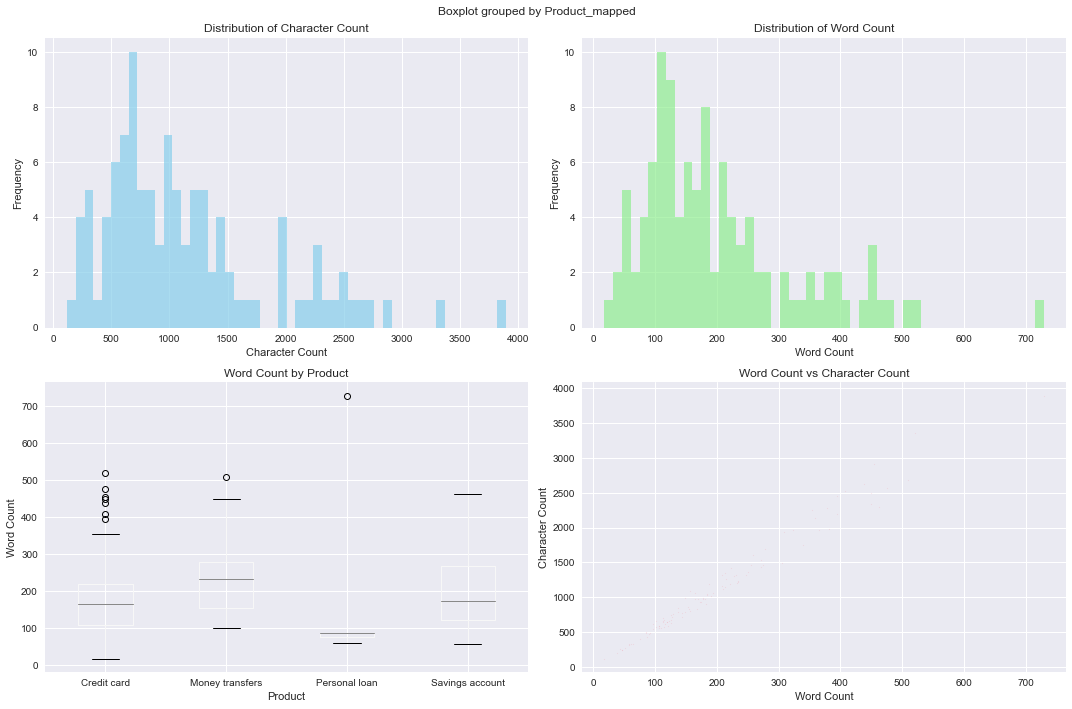

=== WORD FREQUENCY ANALYSIS ===
Top 30 most common words:
xxxx: 656
account: 235
card: 137
credit: 105
bank: 98
xxxxxxxx: 96
money: 86
told: 66
would: 65
wells: 59
fargo: 59
made: 58
funds: 55
called: 53
received: 51
time: 50
fraud: 47
days: 45
payment: 45
back: 43
said: 43
xxxxyear: 43
also: 40
never: 39
case: 38
dispute: 37
number: 37
citi: 35
transaction: 35
transactions: 35
Could not generate word cloud: Only supported for TrueType fonts
Continuing with analysis...
Top 30 most common words:
xxxx: 656
account: 235
card: 137
credit: 105
bank: 98
xxxxxxxx: 96
money: 86
told: 66
would: 65
wells: 59
fargo: 59
made: 58
funds: 55
called: 53
received: 51
time: 50
fraud: 47
days: 45
payment: 45
back: 43
said: 43
xxxxyear: 43
also: 40
never: 39
case: 38
dispute: 37
number: 37
citi: 35
transaction: 35
transactions: 35
Could not generate word cloud: Only supported for TrueType fonts
Continuing with analysis...


In [22]:
# Check if we have narratives to visualize
if len(df_with_narratives) == 0 or 'narrative_length' not in df_with_narratives.columns:
    print("⚠️  No complaint narratives available for visualization. Skipping text analysis charts.")
else:
    # Visualize text length distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Character count distribution
    axes[0, 0].hist(df_with_narratives['narrative_length'], bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of Character Count')
    axes[0, 0].set_xlabel('Character Count')
    axes[0, 0].set_ylabel('Frequency')

    # Word count distribution
    axes[0, 1].hist(df_with_narratives['word_count'], bins=50, alpha=0.7, color='lightgreen')
    axes[0, 1].set_title('Distribution of Word Count')
    axes[0, 1].set_xlabel('Word Count')
    axes[0, 1].set_ylabel('Frequency')

    # Box plot of word count by product
    df_with_narratives.boxplot(column='word_count', by='Product_mapped', ax=axes[1, 0])
    axes[1, 0].set_title('Word Count by Product')
    axes[1, 0].set_xlabel('Product')
    axes[1, 0].set_ylabel('Word Count')

    # Scatter plot: word count vs character count
    axes[1, 1].scatter(df_with_narratives['word_count'], df_with_narratives['narrative_length'], 
                      alpha=0.1, s=1)
    axes[1, 1].set_title('Word Count vs Character Count')
    axes[1, 1].set_xlabel('Word Count')
    axes[1, 1].set_ylabel('Character Count')

    plt.tight_layout()
    plt.show()

    # Word frequency analysis
    print("=== WORD FREQUENCY ANALYSIS ===")

    # Function to clean and tokenize text with fallback
    def clean_and_tokenize(text):
        if pd.isna(text):
            return []
        
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^\w\s]', '', text.lower())
        
        # Try NLTK tokenization first, fallback to simple split
        try:
            tokens = word_tokenize(text)
        except LookupError:
            # Fallback to simple whitespace tokenization
            print("⚠️  NLTK tokenizer not available, using simple tokenization")
            tokens = text.split()
        
        # Remove stopwords
        try:
            stop_words = set(stopwords.words('english'))
        except LookupError:
            # Fallback to basic English stopwords
            stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their'])
        
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        return tokens

    # Sample a subset for word frequency analysis (for performance)
    sample_size = min(10000, len(df_with_narratives))
    sample_df = df_with_narratives.sample(n=sample_size, random_state=42)

    # Tokenize all narratives
    all_tokens = []
    for narrative in sample_df[narrative_col]:
        tokens = clean_and_tokenize(narrative)
        all_tokens.extend(tokens)

    # Get most common words
    word_freq = Counter(all_tokens)
    
    if len(word_freq) > 0:
        top_words = word_freq.most_common(30)

        print("Top 30 most common words:")
        for word, count in top_words:
            print(f"{word}: {count}")

        # Create word cloud
        try:
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

            plt.figure(figsize=(12, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('Word Cloud of Complaint Narratives')
            plt.show()
        except Exception as e:
            print(f"Could not generate word cloud: {e}")
            print("Continuing with analysis...")
    else:
        print("No words found for frequency analysis.")

## 4. Data Cleaning and Preprocessing

Now let's clean the text narratives to improve embedding quality and prepare the final dataset.

In [23]:
# Text cleaning function
def clean_complaint_text(text):
    """
    Clean complaint text for better embedding quality
    """
    if pd.isna(text):
        return None
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove common boilerplate text
    boilerplate_phrases = [
        "i am writing to file a complaint",
        "i would like to file a complaint",
        "this is a complaint about",
        "dear sir or madam",
        "to whom it may concern",
        "i am contacting you regarding",
        "i am writing this letter to",
        "xxxx", "xx/xx/xxxx"
    ]
    
    for phrase in boilerplate_phrases:
        text = text.replace(phrase, "")
    
    # Remove excessive whitespace and normalize
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    # Remove very short texts (less than 20 characters)
    if len(text) < 20:
        return None
    
    return text

# Apply cleaning
print("=== CLEANING COMPLAINT NARRATIVES ===")
print(f"Before cleaning: {len(df_with_narratives)} complaints")

df_with_narratives['cleaned_narrative'] = df_with_narratives[narrative_col].apply(clean_complaint_text)

# Remove rows with None values after cleaning
df_cleaned = df_with_narratives.dropna(subset=['cleaned_narrative']).copy()

print(f"After cleaning: {len(df_cleaned)} complaints")
print(f"Removed: {len(df_with_narratives) - len(df_cleaned)} complaints")

# Compare original vs cleaned text length
df_cleaned['original_length'] = df_cleaned[narrative_col].str.len()
df_cleaned['cleaned_length'] = df_cleaned['cleaned_narrative'].str.len()

print("\n=== TEXT LENGTH COMPARISON ===")
print("Original text length:")
print(df_cleaned['original_length'].describe())
print("\nCleaned text length:")
print(df_cleaned['cleaned_length'].describe())

# Show example of cleaning
print("\n=== CLEANING EXAMPLE ===")
idx = 0
print("Original:")
print(df_cleaned[narrative_col].iloc[idx])
print("\nCleaned:")
print(df_cleaned['cleaned_narrative'].iloc[idx])

=== CLEANING COMPLAINT NARRATIVES ===
Before cleaning: 106 complaints
After cleaning: 106 complaints
Removed: 0 complaints

=== TEXT LENGTH COMPARISON ===
Original text length:
count     106.000000
mean     1147.924528
std       740.177504
min       119.000000
25%       634.500000
50%       979.000000
75%      1432.500000
max      3896.000000
Name: original_length, dtype: float64

Cleaned text length:
count     106.000000
mean     1109.179245
std       714.863527
min       119.000000
25%       590.000000
50%       933.000000
75%      1396.000000
max      3854.000000
Name: cleaned_length, dtype: float64

=== CLEANING EXAMPLE ===
Original:
A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unauthorized and not me. XXXX XXXX confirmed this was fraudulent and immediately closed the card. However, they have failed to remove this from the three credi

In [24]:
# Prepare final dataset
print("=== PREPARING FINAL DATASET ===")

# Select relevant columns for the RAG system
columns_to_keep = [
    'Complaint ID',
    'Product_mapped',
    'Issue',
    'Sub-issue',
    'Company',
    'State',
    'Date received',
    'cleaned_narrative',
    'original_length',
    'cleaned_length'
]

# Create final dataset
final_df = df_cleaned[columns_to_keep].copy()
final_df = final_df.rename(columns={
    'Product_mapped': 'Product',
    'cleaned_narrative': 'Consumer_complaint_narrative'
})

print(f"Final dataset shape: {final_df.shape}")
print(f"Final dataset columns: {final_df.columns.tolist()}")

# Final statistics by product
print("\n=== FINAL DATASET STATISTICS BY PRODUCT ===")
product_stats = final_df.groupby('Product').agg({
    'Consumer_complaint_narrative': 'count',
    'cleaned_length': ['mean', 'median', 'std']
}).round(2)

product_stats.columns = ['Count', 'Mean_Length', 'Median_Length', 'Std_Length']
print(product_stats)

# Save the cleaned dataset
output_path = "../data/filtered_complaints.csv"
final_df.to_csv(output_path, index=False)
print(f"\n✅ Cleaned dataset saved to: {output_path}")

# Summary report
print("\n" + "="*50)
print("SUMMARY REPORT")
print("="*50)
print(f"Original dataset size: {len(df):,} complaints")
print(f"After product filtering: {len(df_filtered):,} complaints ({len(df_filtered)/len(df)*100:.1f}%)")
print(f"After narrative filtering: {len(df_with_narratives):,} complaints ({len(df_with_narratives)/len(df)*100:.1f}%)")
print(f"Final cleaned dataset: {len(final_df):,} complaints ({len(final_df)/len(df)*100:.1f}%)")
print(f"\nTarget products included:")
for product in final_df['Product'].unique():
    count = len(final_df[final_df['Product'] == product])
    print(f"  - {product}: {count:,} complaints")
print(f"\nAverage narrative length: {final_df['cleaned_length'].mean():.0f} characters")
print(f"Ready for embedding and vector store creation! 🚀")

=== PREPARING FINAL DATASET ===
Final dataset shape: (106, 10)
Final dataset columns: ['Complaint ID', 'Product', 'Issue', 'Sub-issue', 'Company', 'State', 'Date received', 'Consumer_complaint_narrative', 'original_length', 'cleaned_length']

=== FINAL DATASET STATISTICS BY PRODUCT ===
                 Count  Mean_Length  Median_Length  Std_Length
Product                                                       
Credit card         50      1048.24          884.0      742.14
Money transfers     13      1370.85         1290.0      644.25
Personal loan        5      1080.00          410.0     1551.72
Savings account     38      1103.68          939.0      544.68

✅ Cleaned dataset saved to: ../data/filtered_complaints.csv

SUMMARY REPORT
Original dataset size: 50,000 complaints
After product filtering: 1,196 complaints (2.4%)
After narrative filtering: 106 complaints (0.2%)
Final cleaned dataset: 106 complaints (0.2%)

Target products included:
  - Credit card: 50 complaints
  - Savings acco